In [1]:
from sklearn.datasets import fetch_mldata
from sklearn import preprocessing
from scipy.stats import norm
import numpy as np
import numpy.random as random
from src.pytorch_cl_vae.model import ClVaeModel
import matplotlib.pyplot as plt
import torch
%matplotlib inline

## 1 - Load the model

In [2]:
fname = '../data/models/cl_vae_mnist_09_20_2018_03_55_PM.pt'
model = ClVaeModel.load_from_ckpt(fname)

## 2 - Load MNIST

In [3]:
datadir = '../data'
mnist = fetch_mldata('MNIST original', data_home=datadir)
mnist.data = mnist.data / 255
num_samples, input_dim = mnist.data.shape
num_classes = len(np.unique(mnist.target))
lb = preprocessing.LabelBinarizer()
lb.fit(mnist.target)
print('MNIST db has been successfully loaded, stored in the: "{}"'.format(datadir + '/mldata'))

MNIST db has been successfully loaded, stored in the: "../data/mldata"


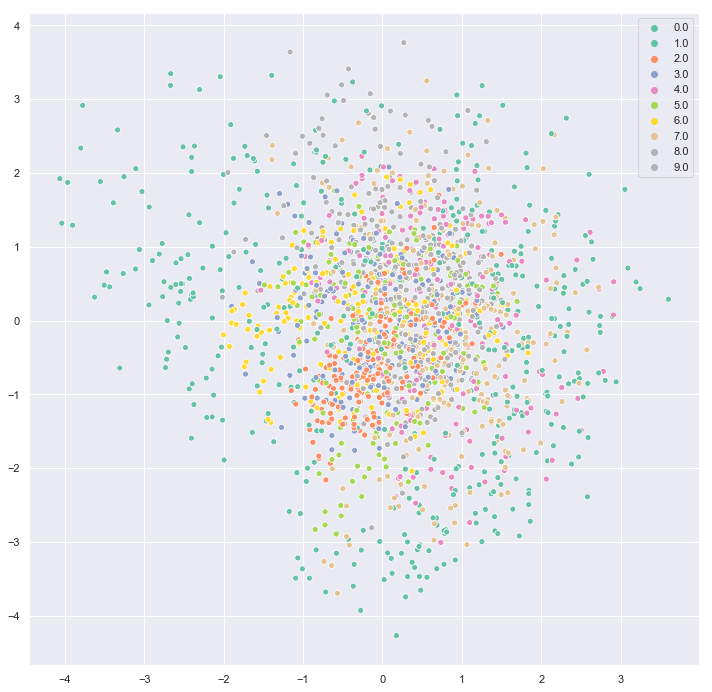

In [4]:
num_examples = 2000
idxs = random.randint(0, num_samples-1, num_examples)
x = mnist.data[idxs]
y = mnist.target[idxs]
y_probs = lb.transform(y)
x_batch = torch.from_numpy(x).float()
ws_batch = [torch.from_numpy(y_probs).float()]

z, _, _ = model.encode(x_batch, ws_batch)

import src.pytorch_cl_vae.utils as utils
plt.figure(figsize=(12,12))
utils.plot_latent(z.detach().numpy(), y)

## 3 - Get some examples to work with

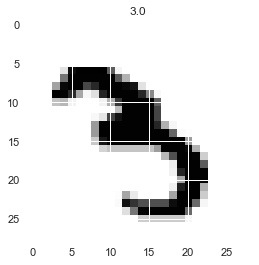

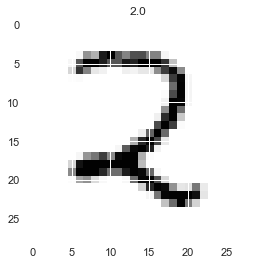

In [5]:
num_examples = 2
idxs = random.randint(0, num_samples-1, num_examples)
x = mnist.data[idxs]
y = mnist.target[idxs]
y_probs = lb.transform(y)
for i in range(x.shape[0]):
    plt.figure()
    img = x[i].reshape([int(np.sqrt(x.shape[-1]))]*2)
    plt.title(y[i])
    plt.imshow(img, cmap='Greys')
    
plt.show()

## 4 - Reconstruction check

tensor([[-0.5023,  1.7967],
        [ 0.2045,  0.0372]])
tensor([[-0.5787,  1.8468],
        [ 0.3023,  0.0588]])
tensor([[0.0682, 0.1523],
        [0.0909, 0.1054]])


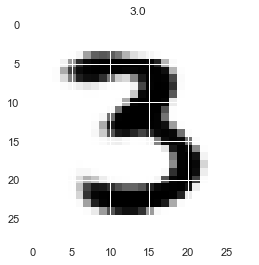

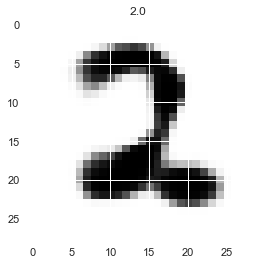

In [6]:
# Encode
x_batch = torch.from_numpy(x).float()
ws_batch = [torch.from_numpy(y_probs).float()]

z, z_mean, z_log_var = model.encode(x_batch, ws_batch)
print("{}\n{}\n{}".format(z, z_mean, z_log_var.exp().sqrt()))
x_decoded = model.decode(z, ws_batch)

x_decoded = x_decoded.detach().numpy()

for i in range(x_decoded.shape[0]):
    plt.figure()
    img = x_decoded[i].reshape([int(np.sqrt(x_decoded.shape[-1]))]*2)
    plt.title(y[i])
    plt.imshow(img, cmap='Greys')
    
plt.show()

## 5 - Generate with fixed ws

(2, 10)
(625, 10)
(625, 2)


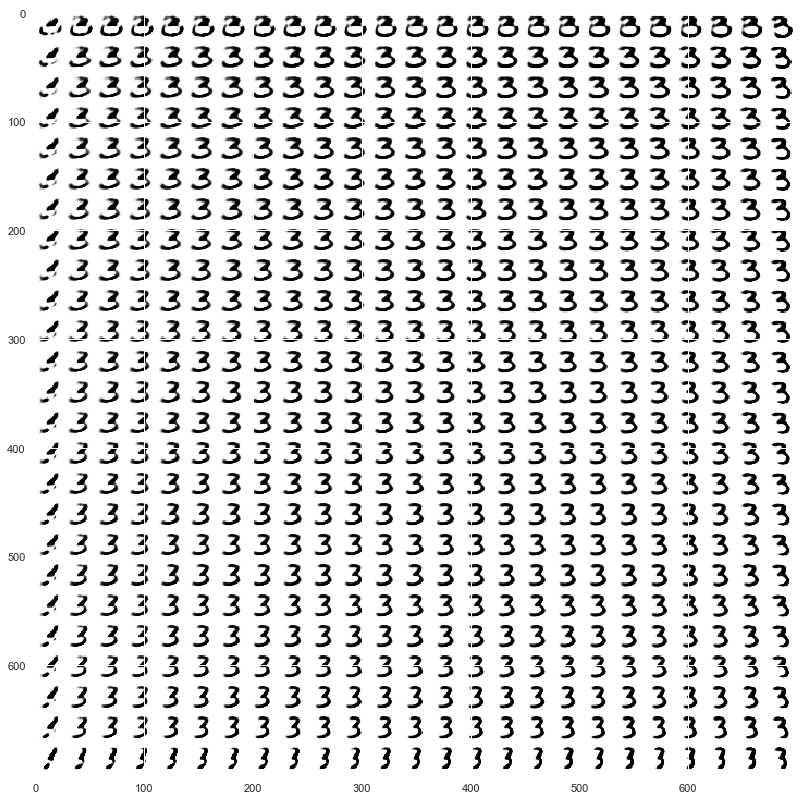

In [7]:
n = 25
w_fixed = ws_batch[0].detach().numpy()
print(w_fixed.shape)
w_fixed = np.tile(y_probs[0][:], (n**2, 1))

print(w_fixed.shape)
z_random = random.normal(size=(z[0].shape))
z1 = norm.ppf(np.linspace(0.00001, 0.99999, n))
zx, zy = np.meshgrid(z1, z1)
z_random = np.stack((zx, zy), axis=-1).reshape((-1, 2))
print(z_random.shape)

z_random = torch.from_numpy(z_random).float()
w_fixed = [torch.from_numpy(w_fixed).float()]

x_decoded = model.decode(z_random, w_fixed)

x_decoded = x_decoded.detach().numpy()

final_img = np.zeros((n*int(np.sqrt(x_decoded.shape[-1])), n*int(np.sqrt(x_decoded.shape[-1]))))

img_size = int(np.sqrt(x_decoded.shape[-1]))
plt.figure(figsize=(14,14))
for i in range(x_decoded.shape[0]):
#     
    img = x_decoded[i].reshape([int(np.sqrt(x_decoded.shape[-1]))]*2)
    final_img[(i % n) * img_size : (i % n + 1) * img_size, (i // n) * img_size : (i // n + 1) * img_size ] = img
#     plt.title(w_fixed[0][i].max(0)[1].detach().numpy())
plt.imshow(final_img, cmap='Greys')

plt.show()

## 6 - Generate with fixed z

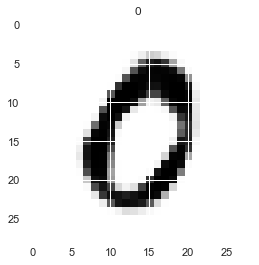

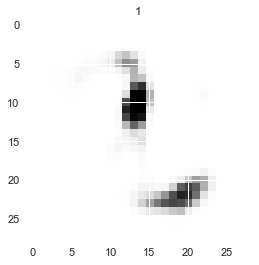

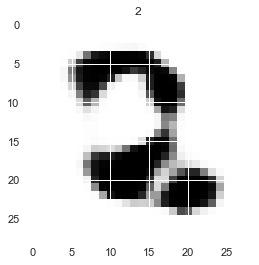

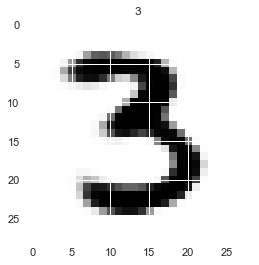

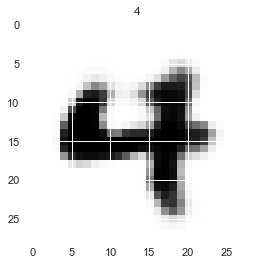

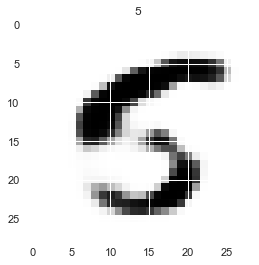

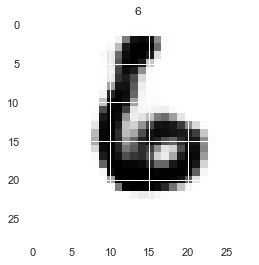

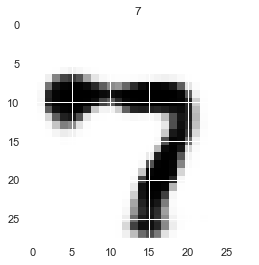

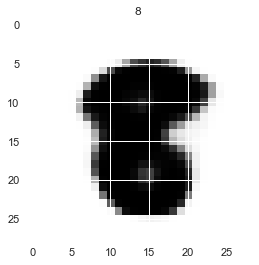

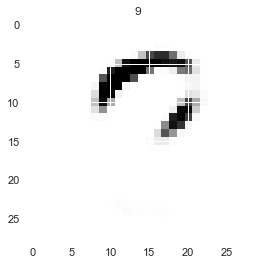

In [8]:
ws_random = np.identity(ws_batch[0].shape[-1])
z_fixed = np.tile(z[0], (ws_random.shape[0], 1))

ws_random = [torch.from_numpy(ws_random).float()]
z_fixed = torch.from_numpy(z_fixed).float()
x_decoded = model.decode(z_fixed, ws_random)
x_decoded = x_decoded.detach().numpy()

for i in range(x_decoded.shape[0]):
    plt.figure()
    img = x_decoded[i].reshape([int(np.sqrt(x_decoded.shape[-1]))]*2)
    plt.title(i)
    plt.imshow(img, cmap='Greys')
    
plt.show()